In [9]:
import numpy as np
from fastdtw import fastdtw
from sklearn.cluster import AffinityPropagation, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.spatial.distance import squareform
import spikeinterface.extractors as se
import spikeinterface.comparison as sc
import seaborn as sns
from spikeinterface.preprocessing import bandpass_filter
from tqdm import tqdm, trange
import time

🚀 DTW Spike Clustering Pipeline
📂 Loading MEArec data...
📊 Processing 500 spikes
🔢 Estimated 124,750 DTW computations
⏱️  Estimated time: 124.8 minutes

🧠 Starting DTW-based spike clustering...
📊 Preprocessing recording...
🔍 Detecting spikes across channels...


Processing channels: 100%|██████████| 4/4 [00:00<00:00, 29.02ch/s]


✅ Detected 500 spikes across channels
📈 Extracting spike waveforms...


Extracting waveforms: 100%|██████████| 500/500 [00:00<00:00, 5470.12spike/s]


✅ Extracted 500 valid waveforms
🔄 Computing DTW distance matrix (500x500)...
📊 Total spike pairs to process: 124,750


Computing DTW distances: 100%|██████████| 124750/124750 [19:26<00:00, 106.93pairs/s, Rate=106.9 pairs/s, ETA=0.0min]


⏱️  DTW computation completed in 19.44 minutes
📈 Average rate: 106.9 pairs/second
🎯 Performing clustering...
🔄 Running Affinity Propagation...


✅ Affinity Propagation: 47 clusters found
🔄 Running Spectral Clustering...


✅ Spectral Clustering: 11 clusters found
📊 Computing 2D embedding for visualization...


🎉 DTW spike clustering completed!

📈 CLUSTERING RESULTS SUMMARY
⏱️  Total computation time: 19.44 minutes
🎯 Affinity Propagation: 47 clusters
🎯 Spectral Clustering: 11 clusters
📊 Processed 500 spikes
📊 Generating visualizations...


Creating plots: 100%|██████████| 6/6 [00:00<00:00, 96.25it/s]


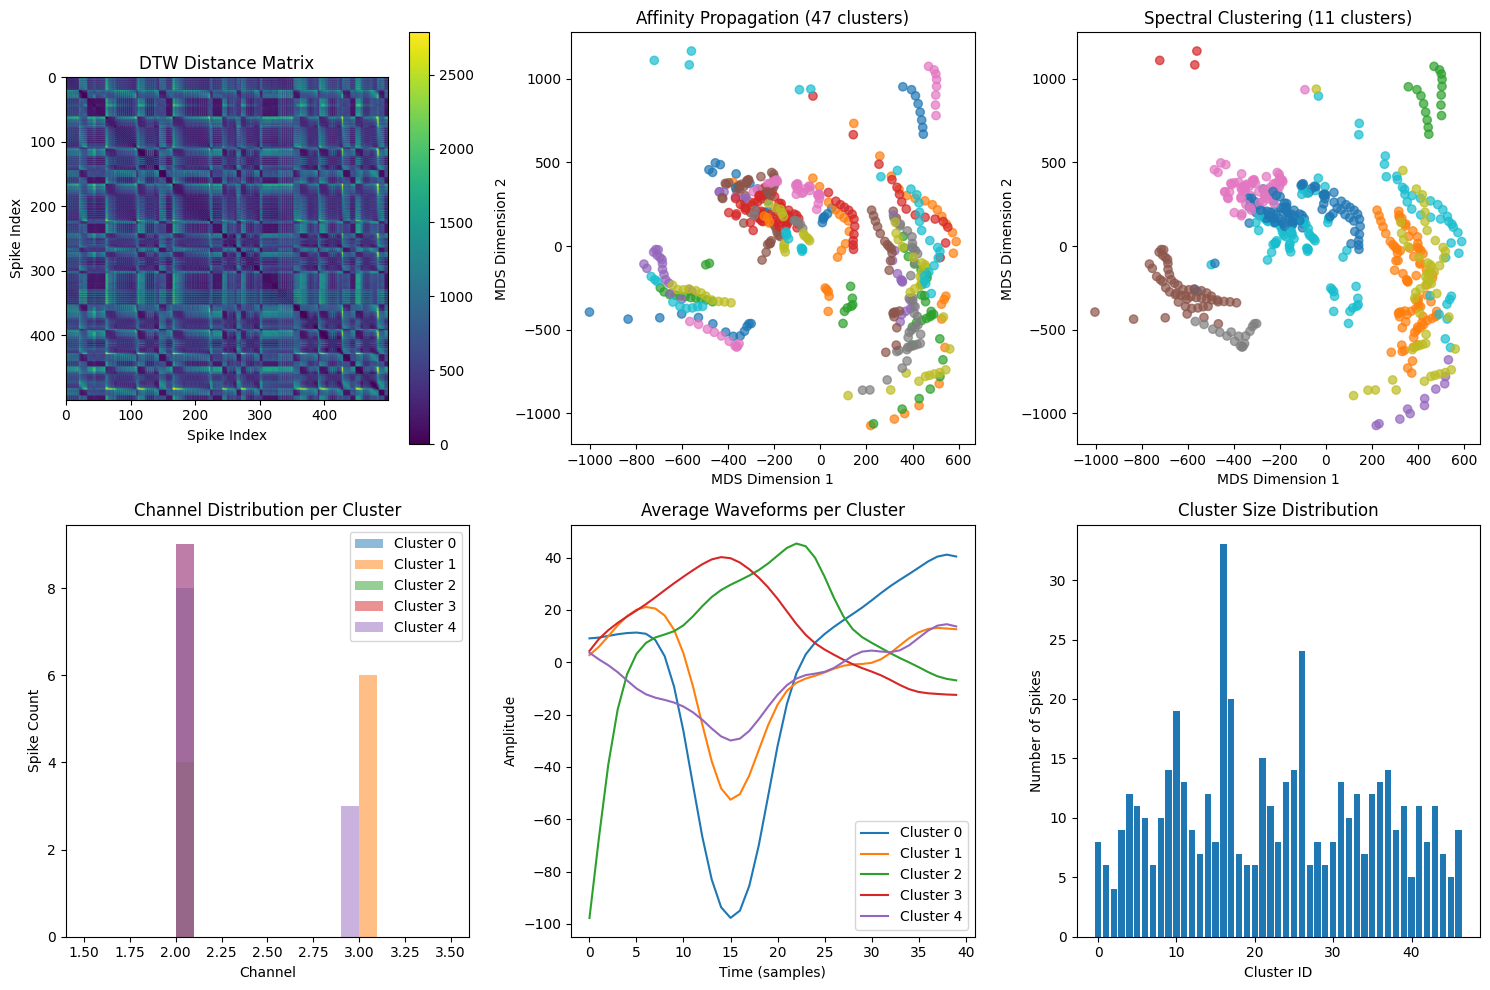

✅ Visualizations completed!


In [3]:
def dtw_spike_clustering(recording, n_spikes_sample=1000, radius=5):
    """
    Implement DTW-based spike clustering without templates with progress tracking
    """
    
    print("🧠 Starting DTW-based spike clustering...")
    
    # 1. Preprocessing and spike detection
    print("📊 Preprocessing recording...")
    recording_filt = bandpass_filter(recording, freq_min=300, freq_max=6000)
    
    def detect_spikes_multi_channel(recording, threshold=4.5):
        """Detect spikes across all channels with progress bar"""
        traces = recording.get_traces()
        spike_events = []
        
        print("🔍 Detecting spikes across channels...")
        for ch in tqdm(range(traces.shape[1]), desc="Processing channels", unit="ch"):
            ch_trace = traces[:, ch]
            std_noise = np.median(np.abs(ch_trace)) / 0.6745
            spike_frames = np.where(np.abs(ch_trace) > threshold * std_noise)[0]
            
            for frame in spike_frames:
                spike_events.append({
                    'time': frame,
                    'channel': ch,
                    'amplitude': np.abs(ch_trace[frame])
                })
        
        # Sort by time and take subset for computational feasibility
        spike_events = sorted(spike_events, key=lambda x: x['time'])
        return spike_events[:n_spikes_sample]
    
    spike_events = detect_spikes_multi_channel(recording_filt)
    print(f"✅ Detected {len(spike_events)} spikes across channels")
    
    # 2. Extract spike waveforms
    print("📈 Extracting spike waveforms...")
    spike_waveforms = []
    spike_metadata = []
    n_pre, n_post = 15, 25
    
    for event in tqdm(spike_events, desc="Extracting waveforms", unit="spike"):
        t, ch = event['time'], event['channel']
        
        # Extract waveform from the channel where spike was detected
        start = max(0, t - n_pre)
        end = min(recording_filt.get_num_frames(), t + n_post)
        
        snippet = recording_filt.get_traces(start_frame=start, end_frame=end)
        
        if snippet.shape[0] == (n_pre + n_post):
            spike_waveforms.append(snippet[:, ch])  # Single channel waveform
            spike_metadata.append({
                'time': t,
                'channel': ch,
                'amplitude': event['amplitude']
            })
    
    spike_waveforms = np.array(spike_waveforms)
    print(f"✅ Extracted {len(spike_waveforms)} valid waveforms")
    
    # 3. Compute DTW distance matrix (the key innovation)
    n_spikes = len(spike_waveforms)
    dtw_distances = np.zeros((n_spikes, n_spikes))
    
    print(f"🔄 Computing DTW distance matrix ({n_spikes}x{n_spikes})...")
    
    # Estimate total operations and time
    total_pairs = (n_spikes * (n_spikes - 1)) // 2
    print(f"📊 Total spike pairs to process: {total_pairs:,}")
    
    start_time = time.time()
    processed_pairs = 0
    
    # Use nested tqdm for better progress tracking
    with tqdm(total=total_pairs, desc="Computing DTW distances", unit="pairs") as pbar:
        for i in range(n_spikes):
            for j in range(i + 1, n_spikes):
                # Use fastDTW with radius constraint for efficiency
                distance, _ = fastdtw(
                    spike_waveforms[i], 
                    spike_waveforms[j], 
                    radius=radius,
                    dist=2  # L2 norm
                )
                dtw_distances[i, j] = distance
                dtw_distances[j, i] = distance  # Symmetric
                
                processed_pairs += 1
                pbar.update(1)
                
                # Update ETA every 100 pairs
                if processed_pairs % 100 == 0:
                    elapsed = time.time() - start_time
                    rate = processed_pairs / elapsed
                    remaining_pairs = total_pairs - processed_pairs
                    eta = remaining_pairs / rate if rate > 0 else 0
                    pbar.set_postfix({
                        'Rate': f'{rate:.1f} pairs/s',
                        'ETA': f'{eta/60:.1f}min'
                    })
    
    total_time = time.time() - start_time
    print(f"⏱️  DTW computation completed in {total_time/60:.2f} minutes")
    print(f"📈 Average rate: {total_pairs/total_time:.1f} pairs/second")
    
    # 4. Clustering using DTW distances
    print("🎯 Performing clustering...")
    
    # Method 1: Affinity Propagation (works directly with distance matrix)
    print("🔄 Running Affinity Propagation...")
    similarity_matrix = -dtw_distances  # Negative distance as similarity
    
    with tqdm(desc="Affinity Propagation", leave=False) as pbar:
        af = AffinityPropagation(
            affinity='precomputed',
            damping=0.5,
            max_iter=200,
            convergence_iter=15,
            verbose=False
        )
        
        af_labels = af.fit_predict(similarity_matrix)
        pbar.update(1)
    
    n_clusters_af = len(set(af_labels))
    print(f"✅ Affinity Propagation: {n_clusters_af} clusters found")
    
    # Method 2: Spectral Clustering with DTW similarity
    print("🔄 Running Spectral Clustering...")
    
    with tqdm(desc="Computing similarity matrix", leave=False) as pbar:
        # Convert to similarity matrix with Gaussian kernel
        sigma = np.median(dtw_distances[dtw_distances > 0])  # Adaptive bandwidth
        similarity_spectral = np.exp(-dtw_distances**2 / (2 * sigma**2))
        pbar.update(1)
    
    with tqdm(desc="Eigenvalue decomposition", leave=False) as pbar:
        # Estimate number of clusters using eigenvalue gap
        eigenvals = np.linalg.eigvals(similarity_spectral)
        eigenvals = np.sort(eigenvals)[::-1]
        gaps = np.diff(eigenvals)
        n_clusters_spectral = np.argmax(gaps[:10]) + 2  # +2 for indexing
        pbar.update(1)
    
    with tqdm(desc="Spectral clustering", leave=False) as pbar:
        spectral = SpectralClustering(
            n_clusters=n_clusters_spectral,
            affinity='precomputed',
            random_state=42
        )
        
        spectral_labels = spectral.fit_predict(similarity_spectral)
        pbar.update(1)
    
    print(f"✅ Spectral Clustering: {n_clusters_spectral} clusters found")
    
    # 5. Dimensionality reduction for visualization
    print("📊 Computing 2D embedding for visualization...")
    from sklearn.manifold import MDS
    
    with tqdm(desc="MDS embedding", leave=False) as pbar:
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, verbose=0)
        spike_embedding = mds.fit_transform(dtw_distances)
        pbar.update(1)
    
    print("🎉 DTW spike clustering completed!")
    
    return {
        'spike_waveforms': spike_waveforms,
        'spike_metadata': spike_metadata,
        'dtw_distances': dtw_distances,
        'af_labels': af_labels,
        'spectral_labels': spectral_labels,
        'spike_embedding': spike_embedding,
        'n_clusters_af': n_clusters_af,
        'n_clusters_spectral': n_clusters_spectral,
        'computation_time': total_time
    }

def visualize_dtw_clustering(results):
    """Visualize the DTW clustering results with progress tracking"""
    
    print("📊 Generating visualizations...")
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    plots_to_generate = [
        "DTW Distance Matrix",
        "Affinity Propagation Embedding", 
        "Spectral Clustering Embedding",
        "Channel Distribution",
        "Average Waveforms",
        "Cluster Size Distribution"
    ]
    
    with tqdm(plots_to_generate, desc="Creating plots") as pbar:
        # 1. DTW distance matrix
        im1 = axes[0,0].imshow(results['dtw_distances'], cmap='viridis')
        axes[0,0].set_title('DTW Distance Matrix')
        axes[0,0].set_xlabel('Spike Index')
        axes[0,0].set_ylabel('Spike Index')
        plt.colorbar(im1, ax=axes[0,0])
        pbar.update(1)
        
        # 2. Affinity Propagation clustering in 2D embedding
        scatter1 = axes[0,1].scatter(
            results['spike_embedding'][:, 0],
            results['spike_embedding'][:, 1],
            c=results['af_labels'],
            cmap='tab10',
            alpha=0.7
        )
        axes[0,1].set_title(f'Affinity Propagation ({results["n_clusters_af"]} clusters)')
        axes[0,1].set_xlabel('MDS Dimension 1')
        axes[0,1].set_ylabel('MDS Dimension 2')
        pbar.update(1)
        
        # 3. Spectral clustering in 2D embedding
        scatter2 = axes[0,2].scatter(
            results['spike_embedding'][:, 0],
            results['spike_embedding'][:, 1],
            c=results['spectral_labels'],
            cmap='tab10',
            alpha=0.7
        )
        axes[0,2].set_title(f'Spectral Clustering ({results["n_clusters_spectral"]} clusters)')
        axes[0,2].set_xlabel('MDS Dimension 1')
        axes[0,2].set_ylabel('MDS Dimension 2')
        pbar.update(1)
        
        # 4. Channel distribution per cluster (Affinity Propagation)
        channels = [meta['channel'] for meta in results['spike_metadata']]
        unique_clusters = np.unique(results['af_labels'])
        
        for cluster_id in unique_clusters[:5]:  # Show first 5 clusters
            cluster_mask = results['af_labels'] == cluster_id
            cluster_channels = np.array(channels)[cluster_mask]
            axes[1,0].hist(cluster_channels, alpha=0.5, label=f'Cluster {cluster_id}', bins=10)
        
        axes[1,0].set_title('Channel Distribution per Cluster')
        axes[1,0].set_xlabel('Channel')
        axes[1,0].set_ylabel('Spike Count')
        axes[1,0].legend()
        pbar.update(1)
        
        # 5. Average waveforms per cluster
        unique_clusters = np.unique(results['af_labels'])
        for cluster_id in unique_clusters[:5]:
            cluster_mask = results['af_labels'] == cluster_id
            cluster_waveforms = results['spike_waveforms'][cluster_mask]
            mean_waveform = np.mean(cluster_waveforms, axis=0)
            axes[1,1].plot(mean_waveform, label=f'Cluster {cluster_id}')
        
        axes[1,1].set_title('Average Waveforms per Cluster')
        axes[1,1].set_xlabel('Time (samples)')
        axes[1,1].set_ylabel('Amplitude')
        axes[1,1].legend()
        pbar.update(1)
        
        # 6. Cluster size distribution
        unique, counts = np.unique(results['af_labels'], return_counts=True)
        axes[1,2].bar(unique, counts)
        axes[1,2].set_title('Cluster Size Distribution')
        axes[1,2].set_xlabel('Cluster ID')
        axes[1,2].set_ylabel('Number of Spikes')
        pbar.update(1)
    
    plt.tight_layout()
    plt.show()
    print("✅ Visualizations completed!")

# Usage example with time estimation
if __name__ == "__main__":
    print("🚀 DTW Spike Clustering Pipeline")
    print("=" * 40)
    
    # Load your MEArec data
    print("📂 Loading MEArec data...")
    recording, sorting_true = se.read_mearec("recordings.h5")
    
    # Estimate computation time
    n_samples = 500  # Adjust based on your computational resources
    estimated_pairs = (n_samples * (n_samples - 1)) // 2
    estimated_time_minutes = estimated_pairs / 1000  # Rough estimate: 1000 pairs/minute
    
    print(f"📊 Processing {n_samples} spikes")
    print(f"🔢 Estimated {estimated_pairs:,} DTW computations")
    print(f"⏱️  Estimated time: {estimated_time_minutes:.1f} minutes")
    print()
    
    # Run DTW-based clustering
    results = dtw_spike_clustering(recording, n_spikes_sample=n_samples)
    
    # Print performance summary
    print("\n" + "=" * 40)
    print("📈 CLUSTERING RESULTS SUMMARY")
    print("=" * 40)
    print(f"⏱️  Total computation time: {results['computation_time']/60:.2f} minutes")
    print(f"🎯 Affinity Propagation: {results['n_clusters_af']} clusters")
    print(f"🎯 Spectral Clustering: {results['n_clusters_spectral']} clusters")
    print(f"📊 Processed {len(results['spike_waveforms'])} spikes")
    
    # Visualize results
    visualize_dtw_clustering(results)

🔍 Comparing Spectral Clustering (11 clusters) to ground truth...
Performance DataFrame columns: ['accuracy', 'recall', 'precision', 'false_discovery_rate', 'miss_rate']
Performance DataFrame dtypes:
accuracy                object
recall                  object
precision               object
false_discovery_rate    object
miss_rate               object
dtype: object


/var/folders/5w/gj94wfqd7mg6xbx29r02m2140000gp/T/ipykernel_34148/2188884291.py:37: DeprecationWarning: `from_times_labels` is deprecated and will be removed in 0.104.0. Note this function requiressamples rather than times so should not be used for clarity purposes. For those working in samples pleaseuse `from_samples_and_labels` instead. For those working in time units (seconds) please use `from_times_and_labels` instead.
  sorting_dtw = se.NumpySorting.from_times_labels(


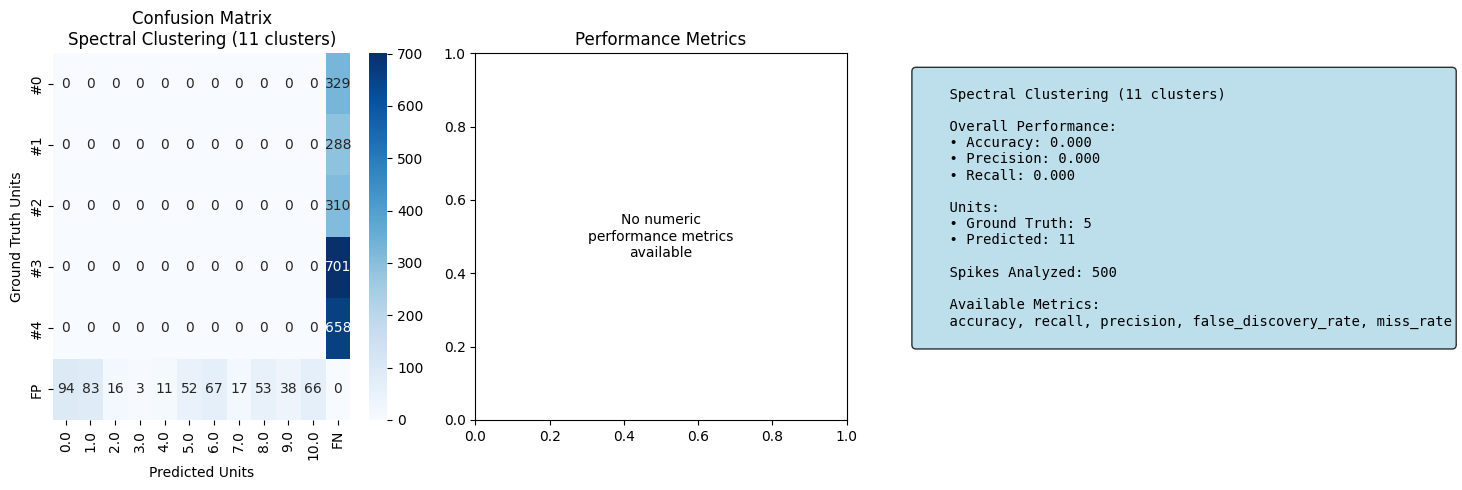

📊 Spectral Clustering (11 clusters) Results:
   Accuracy: 0.000
   Precision: 0.000
   Recall: 0.000

Full Performance DataFrame:
           accuracy recall precision false_discovery_rate miss_rate
gt_unit_id                                                         
#0                0      0         0                    0         0
#1                0      0         0                    0         0
#2                0      0         0                    0         0
#3                0      0         0                    0         0
#4                0      0         0                    0         0


In [13]:
import spikeinterface.comparison as sc
import spikeinterface.extractors as se
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compare_dtw_results_to_ground_truth(results, recording, sorting_true, method='spectral'):
    """
    Compare existing DTW clustering results to ground truth using SpikeInterface
    
    Parameters:
    -----------
    results : dict
        The output from your dtw_spike_clustering function (already computed)
    recording : SpikeInterface recording
        Original recording object
    sorting_true : SpikeInterface sorting
        Ground truth sorting from MEArec
    method : str
        'spectral' or 'affinity' - which clustering result to compare
    """
    
    # Extract the clustering results you want to compare
    if method == 'spectral':
        predicted_labels = results['spectral_labels']
        n_clusters = results['n_clusters_spectral']
        method_name = f"Spectral Clustering ({n_clusters} clusters)"
    else:
        predicted_labels = results['af_labels']
        n_clusters = results['n_clusters_af']
        method_name = f"Affinity Propagation ({n_clusters} clusters)"
    
    # Extract spike times from your existing results
    spike_times = np.array([meta['time'] for meta in results['spike_metadata']])
    
    # Create SpikeInterface sorting object from your DTW results
    sorting_dtw = se.NumpySorting.from_times_labels(
        spike_times,
        predicted_labels,
        sampling_frequency=recording.sampling_frequency
    )
    
    print(f"🔍 Comparing {method_name} to ground truth...")
    
    # Use SpikeInterface comparison
    comparison = sc.compare_sorter_to_ground_truth(
        sorting_true, 
        sorting_dtw,
        exhaustive_gt=True,
        match_score=0.5,
        chance_score=0.1
    )
    
    # Get results
    performance = comparison.get_performance()
    confusion_mat = comparison.get_confusion_matrix()
    
    print(f"Performance DataFrame columns: {performance.columns.tolist()}")
    print(f"Performance DataFrame dtypes:\n{performance.dtypes}")
    
    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Confusion Matrix
    sns.heatmap(confusion_mat.values, 
                annot=True, 
                fmt='d', 
                cmap='Blues',
                xticklabels=confusion_mat.columns,
                yticklabels=confusion_mat.index,
                ax=axes[0])
    axes[0].set_title(f'Confusion Matrix\n{method_name}')
    axes[0].set_xlabel('Predicted Units')
    axes[0].set_ylabel('Ground Truth Units')
    
    # 2. Performance Metrics - FIXED to handle non-numeric data
    numeric_cols = performance.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        cols_to_plot = numeric_cols[:4]  # First 4 numeric columns
        perf_metrics = performance[cols_to_plot].T
        
        sns.heatmap(perf_metrics, 
                    annot=True, 
                    fmt='.3f', 
                    cmap='RdYlGn',
                    center=0.5,
                    ax=axes[1])
        axes[1].set_title('Performance Metrics')
        axes[1].set_xlabel('Ground Truth Units')
        axes[1].set_ylabel('Metrics')
    else:
        axes[1].text(0.5, 0.5, 'No numeric\nperformance metrics\navailable', 
                     ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Performance Metrics')
    
    # 3. Summary Stats - FIXED formatting
    try:
        if 'accuracy' in performance.columns:
            overall_accuracy = performance['accuracy'].mean()
        else:
            overall_accuracy = np.nan
            
        if 'precision' in performance.columns:
            overall_precision = performance['precision'].mean()
        else:
            overall_precision = np.nan
            
        if 'recall' in performance.columns:
            overall_recall = performance['recall'].mean()
        else:
            overall_recall = np.nan
            
    except Exception as e:
        print(f"Warning: Could not compute performance metrics: {e}")
        overall_accuracy = overall_precision = overall_recall = np.nan
    
    # FIXED: Format the values before putting them in the f-string
    acc_str = f"{overall_accuracy:.3f}" if not np.isnan(overall_accuracy) else "N/A"
    prec_str = f"{overall_precision:.3f}" if not np.isnan(overall_precision) else "N/A"
    rec_str = f"{overall_recall:.3f}" if not np.isnan(overall_recall) else "N/A"
    
    summary_text = f"""
    {method_name}
    
    Overall Performance:
    • Accuracy: {acc_str}
    • Precision: {prec_str}
    • Recall: {rec_str}
    
    Units:
    • Ground Truth: {len(sorting_true.unit_ids)}
    • Predicted: {len(sorting_dtw.unit_ids)}
    
    Spikes Analyzed: {len(spike_times)}
    
    Available Metrics:
    {', '.join(performance.columns.tolist())}
    """
    
    axes[2].text(0.05, 0.95, summary_text, 
                 transform=axes[2].transAxes,
                 fontsize=10, 
                 verticalalignment='top',
                 fontfamily='monospace',
                 bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    axes[2].set_xlim(0, 1)
    axes[2].set_ylim(0, 1)
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary - FIXED formatting
    print(f"📊 {method_name} Results:")
    print(f"   Accuracy: {acc_str}")
    print(f"   Precision: {prec_str}")
    print(f"   Recall: {rec_str}")
    
    # Print the full performance DataFrame for debugging
    print(f"\nFull Performance DataFrame:")
    print(performance)
    
    return {
        'comparison': comparison,
        'performance': performance,
        'confusion_matrix': confusion_mat,
        'overall_accuracy': overall_accuracy,
        'overall_precision': overall_precision,
        'overall_recall': overall_recall
    }

# Usage with your existing results:
spectral_comparison = compare_dtw_results_to_ground_truth(
    results, recording, sorting_true, method='spectral'
)

#affinity_comparison = compare_dtw_results_to_ground_truth(
 #   results, recording, sorting_true, method='affinity'
#)


In [15]:
# Extract spike times from your results
spike_times = np.array([meta['time'] for meta in results['spike_metadata']])

# Check if your detected spikes align with ground truth
gt_all_spikes = []
for unit_id in sorting_true.unit_ids:
    gt_spikes = sorting_true.get_unit_spike_train(unit_id)
    gt_all_spikes.extend(gt_spikes)

print(f"Ground truth spikes: {len(gt_all_spikes)}")
print(f"Your detected spikes: {len(spike_times)}")
print(f"Time range - GT: {min(gt_all_spikes)}-{max(gt_all_spikes)}")
print(f"Time range - Yours: {min(spike_times)}-{max(spike_times)}")

# Check temporal overlap
gt_min, gt_max = min(gt_all_spikes), max(gt_all_spikes)
your_min, your_max = min(spike_times), max(spike_times)
print(f"\nTemporal overlap check:")
print(f"GT range: {gt_min} - {gt_max}")
print(f"Your range: {your_min} - {your_max}")
print(f"Overlap: {max(gt_min, your_min)} - {min(gt_max, your_max)}")

# Sample comparison - check first few spikes
print(f"\nFirst 10 GT spikes: {sorted(gt_all_spikes)[:10]}")
print(f"First 10 your spikes: {sorted(spike_times)[:10]}")

Ground truth spikes: 2286
Your detected spikes: 500
Time range - GT: 1204-1919471
Time range - Yours: 1201-14269

Temporal overlap check:
GT range: 1204 - 1919471
Your range: 1201 - 14269
Overlap: 1204 - 14269

First 10 GT spikes: [1204, 1303, 2808, 3880, 4257, 4674, 5129, 5476, 5933, 7090]
First 10 your spikes: [1201, 1202, 1203, 1203, 1203, 1204, 1204, 1204, 1205, 1205]
